# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 005


## Due: October 10, 2024

### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class. Randomly initialize the weight parameters for your network.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points according to the label your classifier would assign them. For instance, if a sample point $x$ is classified as class = 1, then color the point blue, otherwise color the point orange.

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects your solution.

e) Try at least two different learning schedules. For instance, you can start with a constant learning rate and see how that converges. Then, you can repeat everything by using a learning schedule that decays with time.

f) Try choosing your own loss function (**without asking me or the TAs what you should choose**), repeating (d).

g) Now try with three input features, generating your own training and testing data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a test set in the same manner as the training set, classify the samples, and compute the classification accuracy.

h) Using your data from HW1 or any new data you curate if you don't think your HW1 data is appropriate for this assighnment, train your MLP using your training set (80%). Compute the error rate on your test set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 50%, e=10%, f=10%, g=10%, h=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [209]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [210]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.016638,0.827351,0.0
1,1.056355,0.909904,0.0
2,-0.043754,0.909744,1.0
3,1.277842,0.997975,0.0
4,0.841343,0.123382,1.0


Let's message this data into a numpy format.

In [211]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [212]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

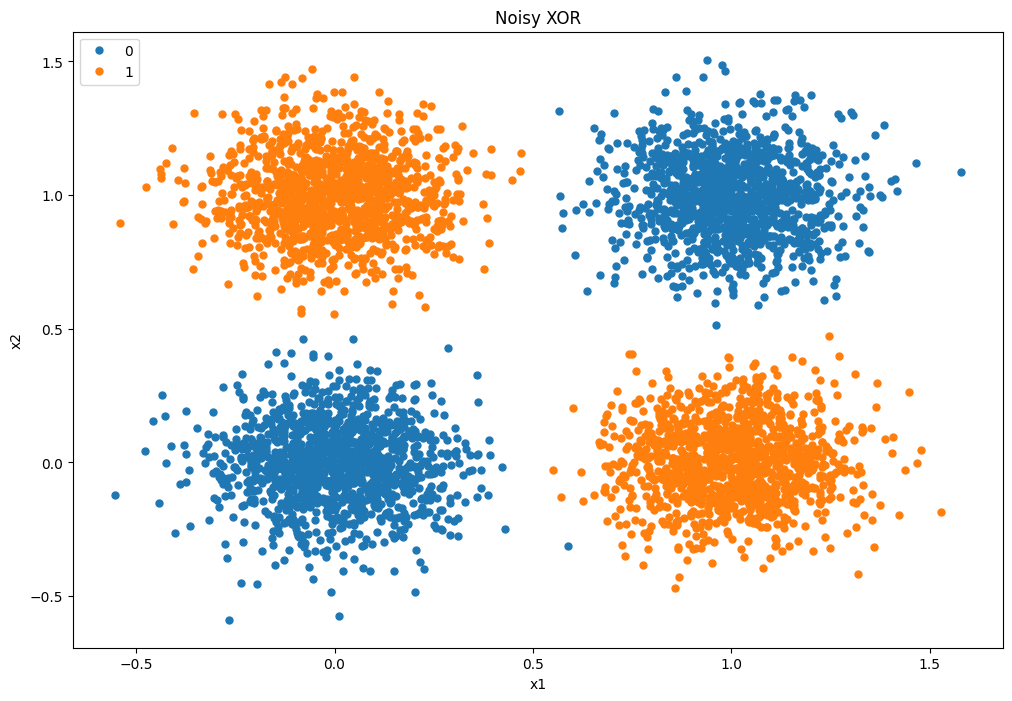

In [213]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

#### Initialize the network paramters

In [214]:
# Initialize weights and biases
input_size = 2
hidden_size = 6 
output_size = 1

# Random initialization of weights and biases
np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) # Weights from input to hidden
W2 = np.random.randn(hidden_size, output_size) # Weights from hidden to output
# b1 = np.zeros((1, hidden_size))               # Bias for hidden layer
# b2 = np.zeros((1, output_size))               # Bias for output layer

b1 = np.random.randn(1, hidden_size)               # Bias for hidden layer
b2 = np.random.randn(1, output_size)               # Bias for output layer

# Activation function (Sigmoid for output, ReLU for hidden)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def sigmoid_derivative(z):
    return z * (1 - z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

# def softplus(z):
#     if z > 100:
#         return z
#     return np.log(1 + np.exp(z))

def softplus(z):
    return np.log(1 + np.exp(np.clip(z, -100, 100))) 

def softplus_derivative(z):
    return sigmoid(z)  # The derivative of softplus is sigmoid(z)


#### Forward Propagation

In [215]:
def forward_propagation(X, W1, b1, W2, b2):
    # Hidden layer computation
    Z1 = np.dot(X, W1) + b1  # Weighted sum at hidden layer
    A1 = relu(Z1)            # Activation for hidden layer (ReLU)

    # Output layer computation with softplus activation
    Z2 = np.dot(A1, W2) + b2  # Weighted sum at output layer
    A2 = softplus(Z2)         # Activation for output layer (Softplus)

    return Z1, A1, A2


#### Backward Propagation

In [216]:
# Backward propagation
def backward_propagation(X, y, Z1, A1, A2, W2): 
    m = X.shape[0]  # Number of examples

    # Compute the derivative for output layer
    dZ2 = A2 - y                   # Error at output layer
    dW2 = (1 / m) * np.dot(A1.T, dZ2)  # Gradient for W2
    db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1)) # Gradient for b2

    # Backpropagate the error to hidden layer
    dA1 = np.dot(dZ2, W2.T)        # Error propagated to hidden layer
    dZ1 = np.multiply(dA1, relu_derivative(Z1))  # Apply ReLU derivative using Z1

    dW1 = (1 / m) * np.dot(X.T, dZ1)  # Gradient for W1
    db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))  # Reshape for db1

    return dW1, db1, dW2, db2



#### Update paramters

In [217]:
# Update weights and biases
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    return W1, b1, W2, b2


#### Training the network

In [218]:
# Training loop
def train(X, y, W1, b1, W2, b2, learning_rate, epochs):
    for i in range(epochs):
        # Forward propagation
        Z1, A1, A2 = forward_propagation(X, W1, b1, W2, b2)

        # Clip A2 to avoid log(0) errors
        A2 = np.clip(A2, 1e-10, 1 - 1e-10)

        # # # Compute the loss (binary cross-entropy)
        # loss = -np.mean(np.multiply(y, np.log(A2)) + np.multiply(1 - y, np.log(1 - A2)))

        # compute loss: softplus
        loss = np.mean(softplus(-y * A2))

        # Backward propagation
        dW1, db1, dW2, db2 = backward_propagation(X, y, Z1, A1, A2, W2)

        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print the loss every 100 epochs
        if i % 100 == 0:
            print("loss:", loss)
            print(f'Epoch {i}, Loss: {loss}')

    return W1, b1, W2, b2


#### Training the model

loss: 0.6828350075901661
Epoch 0, Loss: 0.6828350075901661
loss: 0.5914266403811749
Epoch 100, Loss: 0.5914266403811749
loss: 0.589022420355158
Epoch 200, Loss: 0.589022420355158
loss: 0.5905509479307132
Epoch 300, Loss: 0.5905509479307132
loss: 0.5799770240164074
Epoch 400, Loss: 0.5799770240164074
loss: 0.5749829683704651
Epoch 500, Loss: 0.5749829683704651
loss: 0.6604765437468167
Epoch 600, Loss: 0.6604765437468167
loss: 0.6627248402312819
Epoch 700, Loss: 0.6627248402312819


C:\Users\Rosh\AppData\Local\Temp\ipykernel_17700\3961246507.py:35: RuntimeWarning: overflow encountered in exp
  return np.mean(np.log(1 + np.exp(z)))


loss: 0.677331429306419
Epoch 800, Loss: 0.677331429306419
loss: 0.6476031714203773
Epoch 900, Loss: 0.6476031714203773


IndexError: invalid index to scalar variable.

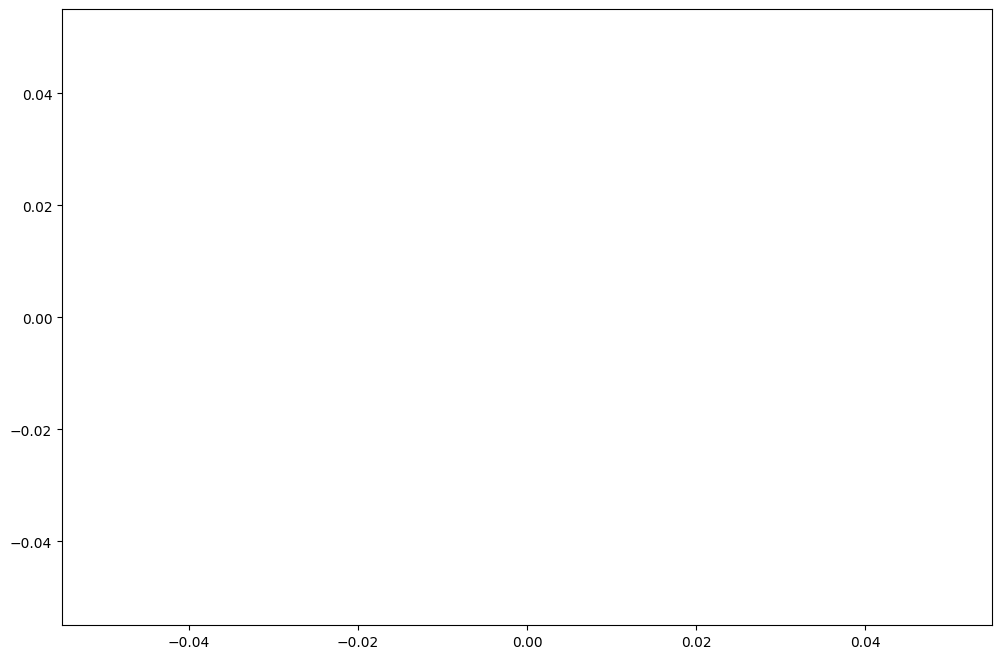

In [219]:
# Set hyperparameters
learning_rate = 0.1
epochs = 1000

# Train the network
W1, b1, W2, b2 = train(X, y, W1, b1, W2, b2, learning_rate, epochs)

# Make predictions
_, _, y_prob = forward_propagation(X, W1, b1, W2, b2)

y_prob = sigmoid(y_prob)

# Plot the data and predictions
plot_data(X, y_prob)


### Working version - not mini batches & entropy

Epoch 0, Loss: 1.0826756575790626
Epoch 100, Loss: 0.4815077670566747
Epoch 200, Loss: 0.3308319385890242
Epoch 300, Loss: 0.2233608537410688
Epoch 400, Loss: 0.1604551526871468
Epoch 500, Loss: 0.1246965353052596
Epoch 600, Loss: 0.10300158281590079
Epoch 700, Loss: 0.08881079591992015
Epoch 800, Loss: 0.07894349255934681
Epoch 900, Loss: 0.07175001091933857


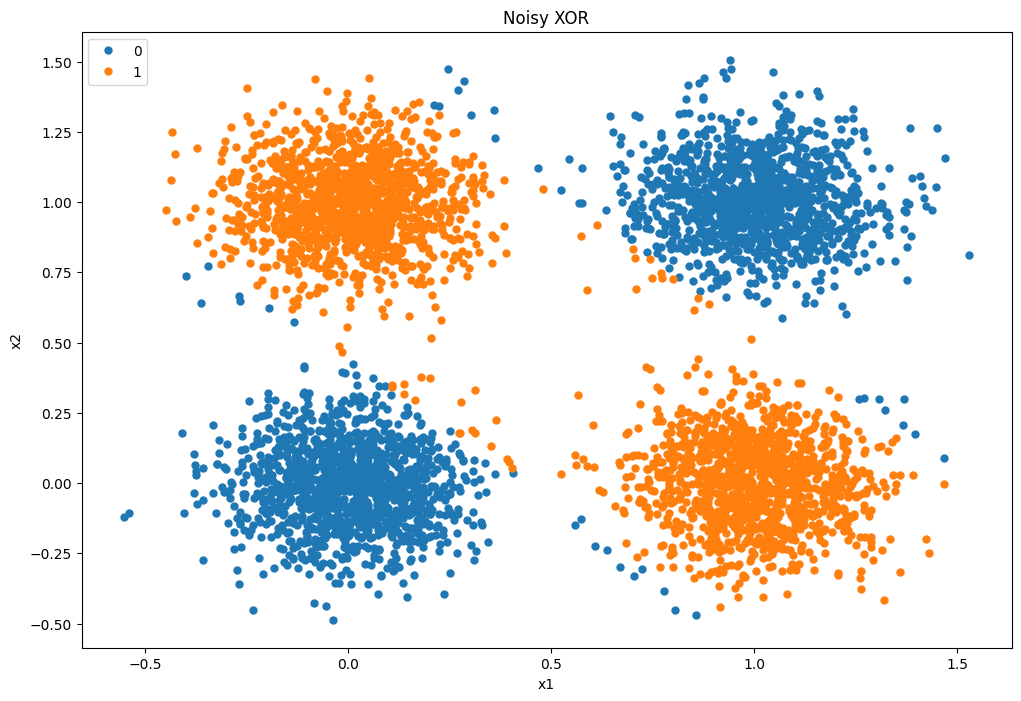

In [197]:

# # Initialize weights and biases
# input_size = 2
# hidden_size = 6
# output_size = 1

# # Random initialization of weights and biases
# np.random.seed(42)
# W1 = np.random.randn(input_size, hidden_size) # Weights from input to hidden
# b1 = np.zeros((1, hidden_size))               # Bias for hidden layer
# W2 = np.random.randn(hidden_size, output_size) # Weights from hidden to output
# b2 = np.zeros((1, output_size))               # Bias for output layer

# # Activation function (Sigmoid for output, ReLU for hidden)
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))

# def relu(z):
#     return np.maximum(0, z)

# def sigmoid_derivative(z):
#     return z * (1 - z)

# def relu_derivative(z):
#     return np.where(z > 0, 1, 0)

# def forward_propagation(X, W1, b1, W2, b2):
#     # Hidden layer computation
#     Z1 = np.dot(X, W1) + b1  # Weighted sum at hidden layer
#     A1 = relu(Z1)            # Activation for hidden layer (ReLU)

#     # Output layer computation
#     Z2 = np.dot(A1, W2) + b2  # Weighted sum at output layer
#     A2 = sigmoid(Z2)          # Activation for output layer (Sigmoid)

#     return Z1, A1, A2

# # Backward propagation
# def backward_propagation(X, y, Z1, A1, A2, W2): 
#     m = X.shape[0]  # Number of examples

#     # Compute the derivative for output layer
#     dZ2 = A2 - y                   # Error at output layer
#     dW2 = (1 / m) * np.dot(A1.T, dZ2)  # Gradient for W2
#     db2 = (1 / m) * np.reshape(np.sum(dZ2, axis=0), (1, -1)) # Gradient for b2

#     # Backpropagate the error to hidden layer
#     dA1 = np.dot(dZ2, W2.T)        # Error propagated to hidden layer
#     dZ1 = np.multiply(dA1, relu_derivative(Z1))  # Apply ReLU derivative using Z1

#     dW1 = (1 / m) * np.dot(X.T, dZ1)  # Gradient for W1
#     db1 = (1 / m) * np.reshape(np.sum(dZ1, axis=0), (1, -1))  # Reshape for db1

#     return dW1, db1, dW2, db2

# # Update weights and biases
# def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
#     W1 -= learning_rate * dW1
#     b1 -= learning_rate * db1
#     W2 -= learning_rate * dW2
#     b2 -= learning_rate * db2

#     return W1, b1, W2, b2

# # Training loop
# def train(X, y, W1, b1, W2, b2, learning_rate, epochs):
#     for i in range(epochs):
#         # Forward propagation
#         Z1, A1, A2 = forward_propagation(X, W1, b1, W2, b2)

#         # Clip A2 to avoid log(0) errors
#         A2 = np.clip(A2, 1e-10, 1 - 1e-10)

#         # # Compute the loss (binary cross-entropy)
#         loss = -np.mean(np.multiply(y, np.log(A2)) + np.multiply(1 - y, np.log(1 - A2)))

#         # compute loss - 
#         # In the training loop
#         # loss = compute_loss(y, A2)

#         # Backward propagation
#         dW1, db1, dW2, db2 = backward_propagation(X, y, Z1, A1, A2, W2)

#         # Update parameters
#         W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

#         # Print the loss every 100 epochs
#         if i % 100 == 0:
#             print(f'Epoch {i}, Loss: {loss}')

#     return W1, b1, W2, b2

# # Set hyperparameters
# learning_rate = 0.1
# epochs = 1000

# # Train the network
# W1, b1, W2, b2 = train(X, y, W1, b1, W2, b2, learning_rate, epochs)

# # Make predictions
# _, _, y_prob = forward_propagation(X, W1, b1, W2, b2)

# # Plot the data and predictions
# plot_data(X, y_prob)

